In [80]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

TRAIN_PERC = 0.8
VALID_PERC = 0.1
TEST_PERC = 0.1

IMAGES_PATH = "../data/ISIC_2019_Training_Input"
METADATA_PATH = "../data/ISIC_2019_Training_Metadata.csv"
OUTPUTS_PATH = "../data/ISIC_2019_Training_GroundTruth.csv"
DATASET_OUTPUT_PATH = "../data/datasets/1.0"

# Loading data

## Input data
Lists all images and creates DataFrame with image and image path columns.

In [51]:
images = [f for f in os.listdir(IMAGES_PATH) if f.endswith('.jpg') or f.endswith('.png')]
image_paths = [os.path.join(IMAGES_PATH, image) for image in images]
images = [image.replace('.jpg', '').replace('.png', '') for image in images]
images_df = pd.DataFrame({'image': images, 'image_path': image_paths})


print(f"Number of total images: {images_df.image.nunique()}")
display(images_df.head(5))


Number of total images: 25331


,image,image_path
0,ISIC_0027284,../data/ISIC_2019_Training_Input/ISIC_0027284.jpg
1,ISIC_0062103,../data/ISIC_2019_Training_Input/ISIC_0062103.jpg
2,ISIC_0071401,../data/ISIC_2019_Training_Input/ISIC_0071401.jpg
3,ISIC_0064682,../data/ISIC_2019_Training_Input/ISIC_0064682.jpg
4,ISIC_0058050,../data/ISIC_2019_Training_Input/ISIC_0058050.jpg


## Output data

,image,target
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


Text(0, 0.5, 'Count')

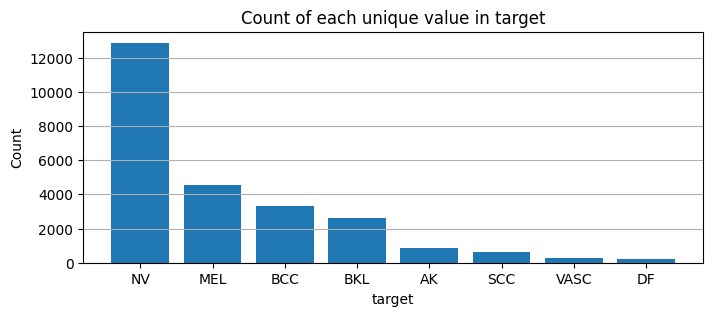

In [87]:
outputs_df = pd.read_csv(OUTPUTS_PATH)
classes = [col for col in outputs_df.columns if col != 'image']
outputs_df['target'] = outputs_df.loc[:, classes].apply(
    lambda x: classes[[i for i, val in enumerate(x.tolist()) if val == 1][0]], axis=1
)
outputs_df = outputs_df[['image', 'target']]
display(outputs_df.head(5))

# Create the subplots
fig = plt.figure(figsize=(8, 3))

# Plot the first feature
ax = fig.add_subplot(1, 1, 1)
value_counts1 = outputs_df['target'].value_counts()
ax.bar(value_counts1.index.astype(str), value_counts1.values)
ax.grid(axis='y')
ax.set_title(f'Count of each unique value in target')
ax.set_xlabel('target')
ax.set_ylabel('Count')



## Metadata features

In [53]:
metadata_df = pd.read_csv(METADATA_PATH)
display(metadata_df.head(5))

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


### Handling NaN values

In [54]:
metadata_df.isna().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

In [55]:
metadata_df.nunique()

image                  25331
age_approx                18
anatom_site_general        8
lesion_id              11847
sex                        2
dtype: int64

Since there is small amount of data that is missing for age and sex, decsision was made to fill missing values in the following way:
- age NaN values are filled with median value
- sex NaN values are filled with the previous non-NaN value

Since lesion ID is not informative as such as it contains 11847 unique values, decision was made to extract prefix of lesion ID and use it as a feature. Missing values are filled treated as a new value "unknown".

Similar thing was done for the `anatom_site_general` feature; NaN values are replaced with "unkown" value.

In [58]:
metadata_df['age_approx'] = metadata_df['age_approx'].fillna(metadata_df['age_approx'].median())
metadata_df['sex'] = metadata_df['sex'].ffill()
metadata_df['lesion_id'] = metadata_df['lesion_id'].fillna('unknown')
metadata_df['anatom_site_general'] = metadata_df['anatom_site_general'].fillna('unknown')
metadata_df['lesion_id'] = metadata_df['lesion_id'].str.split('_').str[0]

metadata_df.nunique()

image                  25331
age_approx                18
anatom_site_general        9
lesion_id                  4
sex                        2
dtype: int64

/tmp/ipykernel_258920/3363190486.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


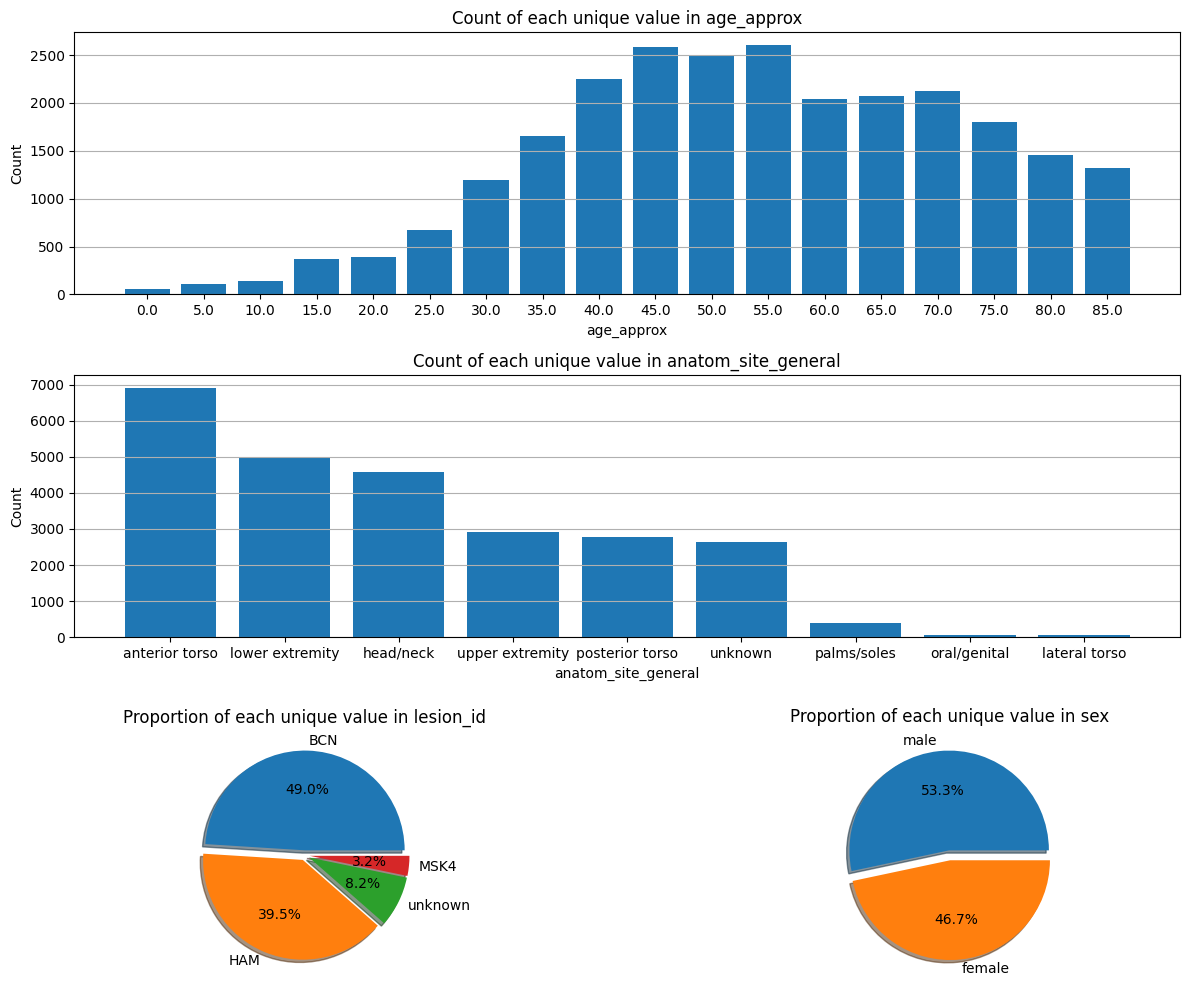

In [136]:
def visualize_features(df):
    # List of features to plot
    features = ['age_approx', 'anatom_site_general', 'lesion_id', 'sex']

    # Create the subplots
    fig = plt.figure(figsize=(12, 10))

    # Plot the first feature
    ax1 = fig.add_subplot(3, 1, 1)
    value_counts1 = df[features[0]].value_counts().sort_index()
    ax1.bar(value_counts1.index.astype(str), value_counts1.values)
    ax1.grid(axis='y')
    ax1.set_title(f'Count of each unique value in {features[0]}')
    ax1.set_xlabel(features[0])
    ax1.set_ylabel('Count')

    # Plot the second feature
    ax2 = fig.add_subplot(3, 1, 2)
    value_counts2 = df[features[1]].value_counts()
    ax2.bar(value_counts2.index.astype(str), value_counts2.values)
    ax2.grid(axis='y')
    ax2.set_title(f'Count of each unique value in {features[1]}')
    ax2.set_xlabel(features[1])
    ax2.set_ylabel('Count')

    # Create a grid for the bottom two plots
    grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.4)

    # Plot the third feature as a pie chart with shadow and explode
    ax3 = fig.add_subplot(grid[2, 0])
    value_counts3 = df[features[2]].value_counts()
    explode3 = [0.05] * len(value_counts3)  # Explode all slices equally for demonstration
    ax3.pie(value_counts3.values, labels=value_counts3.index.astype(str), autopct='%1.1f%%', shadow=True, explode=explode3)
    ax3.set_title(f'Proportion of each unique value in {features[2]}')

    # Plot the fourth feature as a pie chart with shadow and explode
    ax4 = fig.add_subplot(grid[2, 1])
    value_counts4 = df[features[3]].value_counts()
    explode4 = [0.05] * len(value_counts4)  # Explode all slices equally for demonstration
    ax4.pie(value_counts4.values, labels=value_counts4.index.astype(str), autopct='%1.1f%%', shadow=True, explode=explode4)
    ax4.set_title(f'Proportion of each unique value in {features[3]}')

    plt.tight_layout()
    plt.show()
    
visualize_features(metadata_df)

## Merge DataFrames

In [62]:
if len(images_df) != len(outputs_df):
    raise RuntimeError(
        f'Different size of input and output DataFrames: {len(images_df)} != {len(outputs_df)}'
        )

if len(images_df) != len(metadata_df):
    raise RuntimeError(
        f'Different size of input and metadata DataFrames: {len(images_df)} != {len(metadata_df)}'
        )

all_df = pd.merge(images_df, metadata_df, on='image')
if len(all_df) != len(images_df):
    raise RuntimeError(
        f'Different size of merged and input DataFrames: {len(images_df)} != {len(metadata_df)}'
        )

all_df = pd.merge(all_df, outputs_df, on='image')
if len(all_df) != len(outputs_df):
    raise RuntimeError(
        f'Different size of input and output DataFrames: {len(all_df)} != {len(outputs_df)}'
    )

all_df.head(10)

,image,image_path,age_approx,anatom_site_general,lesion_id,sex,target
0,ISIC_0027284,../data/ISIC_2019_Training_Input/ISIC_0027284.jpg,15.0,head/neck,HAM,male,NV
1,ISIC_0062103,../data/ISIC_2019_Training_Input/ISIC_0062103.jpg,80.0,head/neck,BCN,male,MEL
2,ISIC_0071401,../data/ISIC_2019_Training_Input/ISIC_0071401.jpg,55.0,anterior torso,BCN,male,MEL
3,ISIC_0064682,../data/ISIC_2019_Training_Input/ISIC_0064682.jpg,40.0,anterior torso,BCN,male,VASC
4,ISIC_0058050,../data/ISIC_2019_Training_Input/ISIC_0058050.jpg,35.0,anterior torso,BCN,female,MEL
5,ISIC_0033576,../data/ISIC_2019_Training_Input/ISIC_0033576.jpg,85.0,unknown,HAM,male,BKL
6,ISIC_0061907,../data/ISIC_2019_Training_Input/ISIC_0061907.jpg,60.0,lower extremity,BCN,female,BCC
7,ISIC_0030814,../data/ISIC_2019_Training_Input/ISIC_0030814.jpg,45.0,lower extremity,HAM,female,NV
8,ISIC_0029065,../data/ISIC_2019_Training_Input/ISIC_0029065.jpg,40.0,unknown,HAM,female,NV
9,ISIC_0032460,../data/ISIC_2019_Training_Input/ISIC_0032460.jpg,70.0,posterior torso,HAM,male,BKL


## Preparing features

Standard scaling was applied to age column and the other features are one-hot-encoded since those are categorical cannot be ordered in any way.

In [78]:
"""Does one hot encoding and standard scaling od the features."""
metadata_features_df = all_df.copy()
# Apply one hot encoding to 'anatom_site_general', 'lesion_id', 'sex'
one_hot_dfs = [pd.get_dummies(metadata_features_df[col], prefix=col, dtype=float) for col in ['anatom_site_general', 'lesion_id', 'sex']]
# Apply standard scaller to age_approx
metadata_features_df['age'] = StandardScaler().fit_transform(metadata_features_df[['age_approx']])
# Concatenate metadata features
metadata_features_df = pd.concat((metadata_features_df[['image', 'age']], *one_hot_dfs), axis=1)

metadata_features_df.head(3)

,image,age,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lateral torso,anatom_site_general_lower extremity,anatom_site_general_oral/genital,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_unknown,anatom_site_general_upper extremity,lesion_id_BCN,lesion_id_HAM,lesion_id_MSK4,lesion_id_unknown,sex_female,sex_male
0,ISIC_0027284,-2.172320,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,ISIC_0062103,1.444018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,ISIC_0071401,0.053119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Split

## Prepare metadata for the split

To make sure that we have the same data distribution in training, validation and testing split, we will split individual subsets of data that share feature unique combinations with taget values. Because age has too many unique values, we split age into two separate groups; people under median age and people above median age.

In [79]:
all_df['age_less_median'] = (all_df['age_approx'] < all_df['age_approx'].median()).astype(str)
all_df['split_column'] = all_df[['target', 'age_less_median', 'anatom_site_general', 'lesion_id', 'sex']].apply(lambda x: '_'.join(x), axis=1)
    
split_column_unique_lst = all_df['split_column'].unique().tolist()

print(f"There is {len(split_column_unique_lst)} unique values to split on.")

There is 472 unique values to split on.


## Split logic

In [139]:
np.random.seed(42)

train_dfs, valid_dfs, test_dfs = [], [], []
for col in split_column_unique_lst:
    # Extract DatAFrame for the unique value
    class_df  = all_df[all_df['split_column'] == col]
    # Sample train data
    train_class_df = class_df.sample(frac=TRAIN_PERC)
    # Extract the remaining data
    remaining_df = class_df[~class_df.image.isin(train_class_df.image)]
    # Sample validation data
    valid_class_df = remaining_df.sample(frac=VALID_PERC/(VALID_PERC + TEST_PERC))
    # Use the remaining data for testing
    test_class_df = remaining_df[~remaining_df.image.isin(valid_class_df.image)]

    assert len(class_df) == len(train_class_df) + len(valid_class_df) + len(test_class_df)
    
    train_dfs.append(train_class_df)
    valid_dfs.append(valid_class_df)
    test_dfs.append(test_class_df)

# COncatenate DataFrames
train_df = pd.concat(train_dfs, ignore_index=True)
valid_df = pd.concat(valid_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

### Visualize split statistics

/tmp/ipykernel_258920/3363190486.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


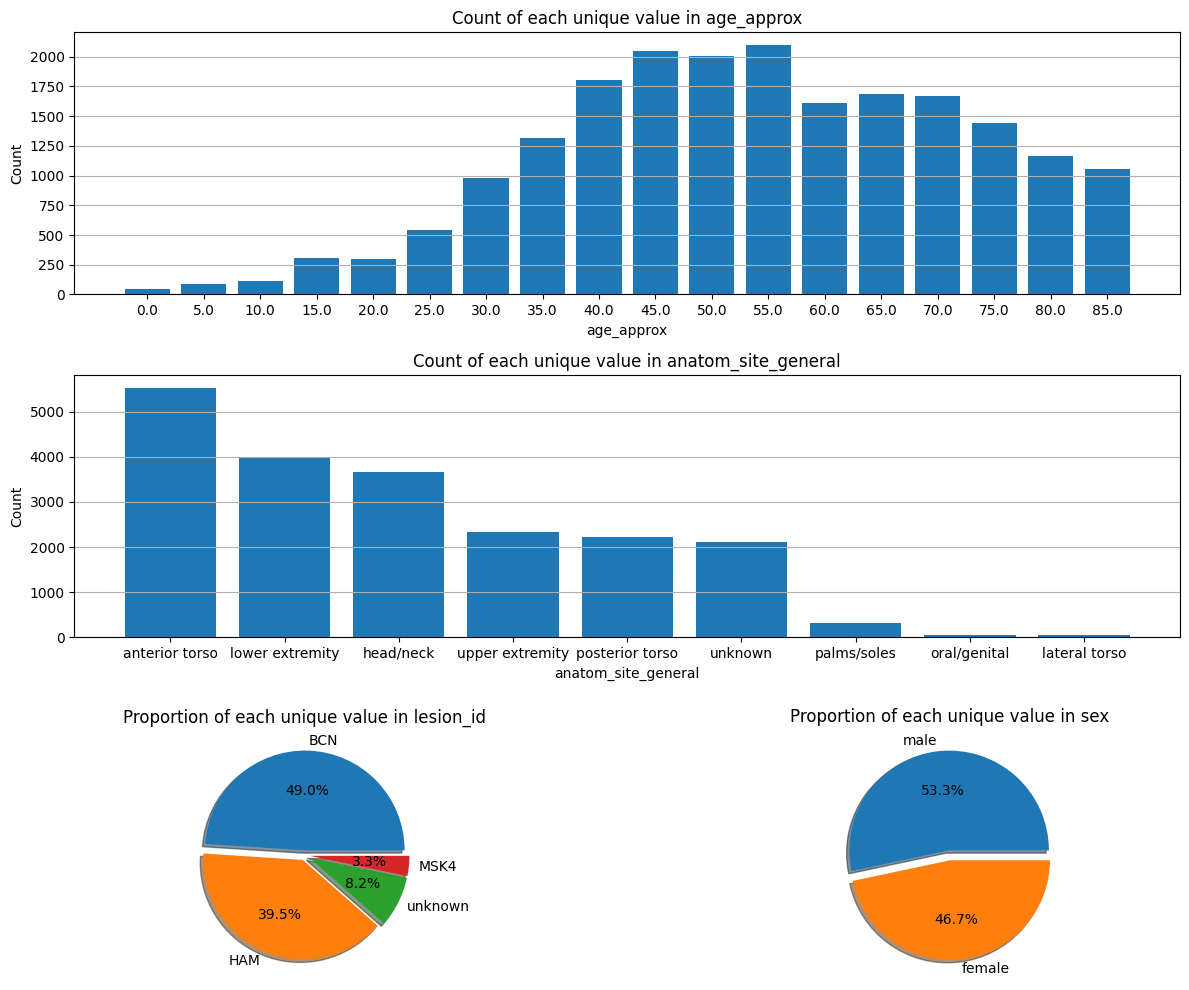

/tmp/ipykernel_258920/3363190486.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


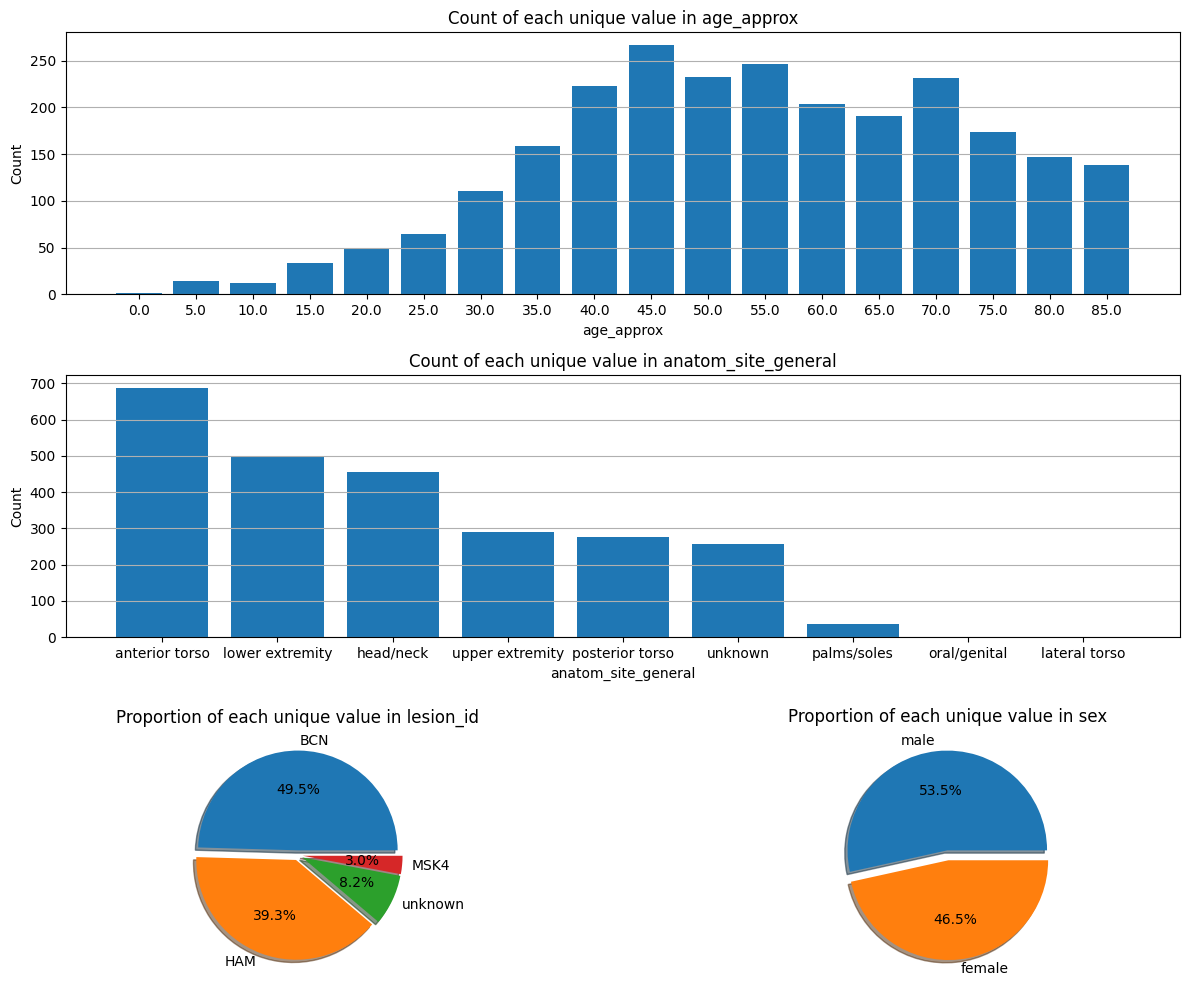

/tmp/ipykernel_258920/3363190486.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


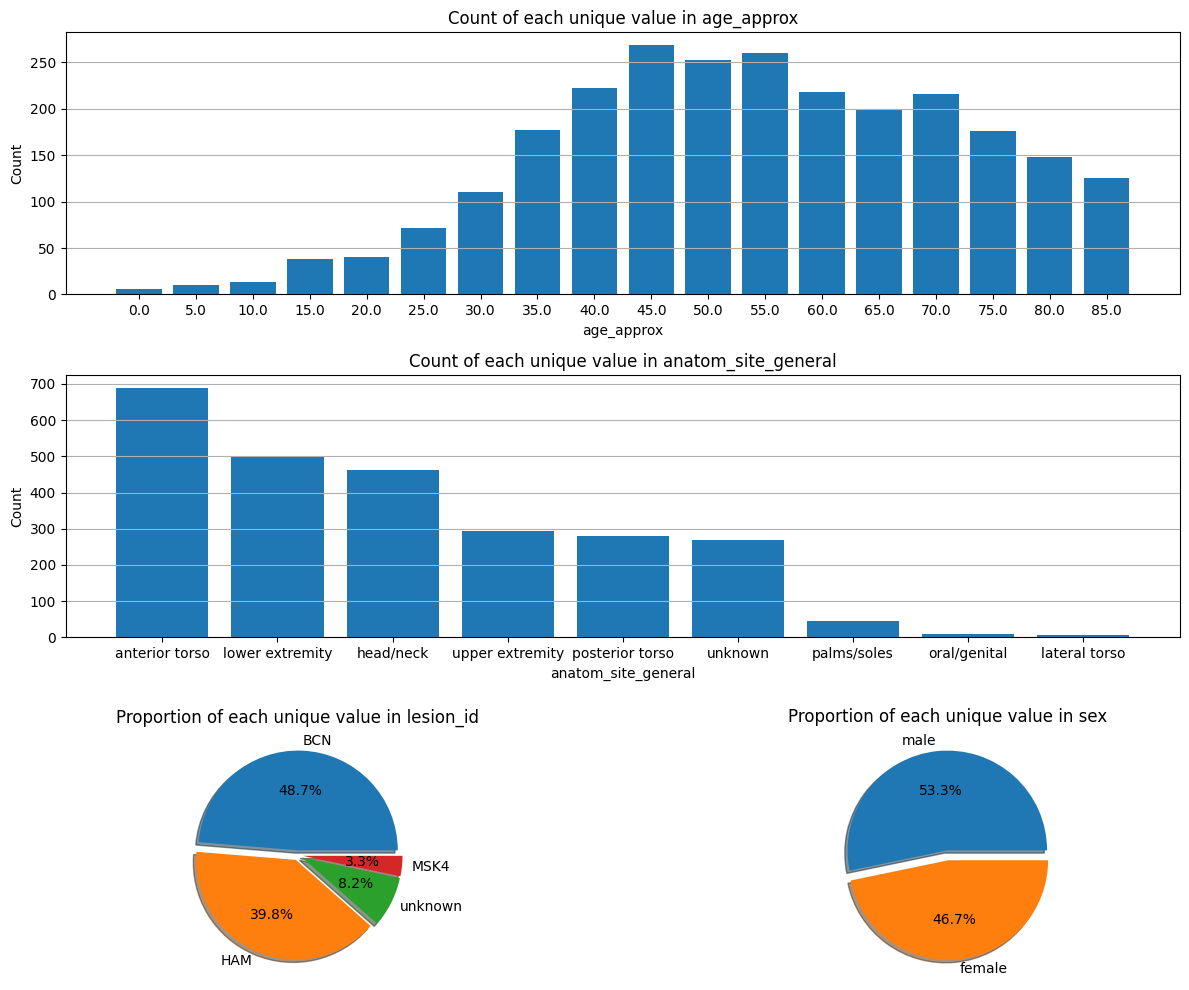

Number of images in train dataframe: 20276
Number of images in valid dataframe: 2503
Number of images in test_df dataframe: 2552


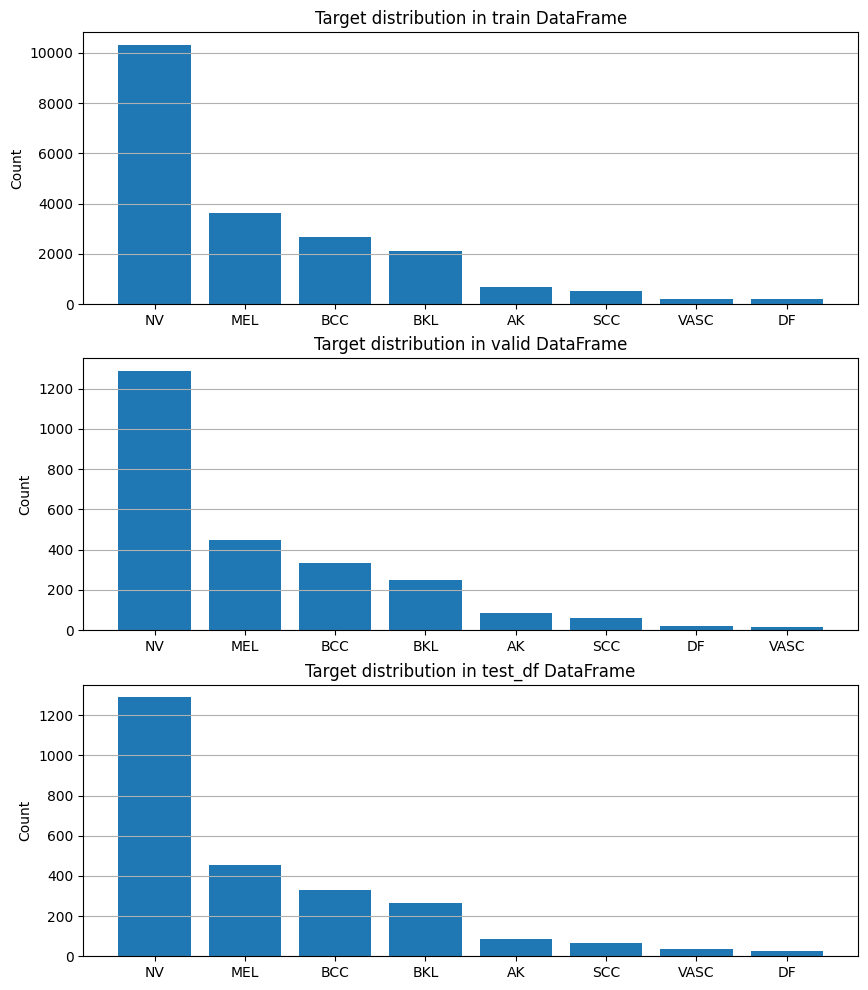

In [140]:
# Visualize features for each DataFrame
visualize_features(train_df)
visualize_features(valid_df)
visualize_features(test_df)

# Create the subplots
fig = plt.figure(figsize=(10, 12))

for i, (df, name) in enumerate([(train_df, "train"), (valid_df, "valid"), (test_df, "test_df")]):
    print(f"Number of images in {name} dataframe: {df.image.nunique()}")
    ax = fig.add_subplot(3, 1, i+1)
    value_counts = df['target'].value_counts()
    ax.bar(value_counts.index.astype(str), value_counts.values)
    ax.grid(axis='y')
    ax.set_title(f'Target distribution in {name} DataFrame')
    ax.set_ylabel('Count')


## Split postprocessing

In [141]:
# Merge with metadata features
train_df = pd.merge(train_df[['image', 'image_path', 'target']], metadata_features_df, on='image')
valid_df = pd.merge(valid_df[['image', 'image_path', 'target']], metadata_features_df, on='image')
test_df = pd.merge(test_df[['image', 'image_path', 'target']], metadata_features_df, on='image')

assert len(set(train_df.image.unique()).intersection(set(valid_df.image.unique()))) == 0
assert len(set(valid_df.image.unique()).intersection(set(test_df.image.unique()))) == 0
assert len(set(train_df.image.unique()).intersection(set(test_df.image.unique()))) == 0

class_encoder = {t: i for i, t in enumerate(train_df.target.unique())}
for df in [train_df, valid_df, test_df]:
    df['class_name'] = df['target']
    df['target'] = df['class_name'].map(class_encoder)

display('Train DataFrame', train_df.head(10))
display('Valid DataFrame', valid_df.head(10))
display('Test DataFrame', test_df.head(10))

# Save data

In [103]:
# train_df.to_pickle(os.path.join(DATASET_OUTPUT_PATH, 'train.pkl'))
# valid_df.to_pickle(os.path.join(DATASET_OUTPUT_PATH, 'valid.pkl'))
# test_df.to_pickle(os.path.join(DATASET_OUTPUT_PATH, 'test.pkl'))